# 3.4 季節成分が複数ある場合の予測モデル

## 3.4.4 時系列特徴量を生成しテーブルデータを作ろう

### 生成する時系列特徴量
* ラグ特徴量（ラグ1）：lag1
* ローリング特徴量（1期前までの1日間の平均の平均）：window48
* エクスパンディング特徴量（1期前までの平均）：expanding
* 三角関数特徴量（48周期）：sin48, cos48
* 三角関数特徴量（336周期）：sin336, cos336

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

import warnings
warnings.simplefilter('ignore')


In [2]:
dataset = sm.datasets.get_rdataset(
    'taylor', 'forecast'
)
df_tbl = dataset.data
df_tbl.columns = ['y']
df_tbl.head()


,y
0,22262
1,21756
2,22247
3,22759
4,22549


In [3]:
# ラグ特徴量（ラグ1）
df_tbl['lag1'] = df_tbl['y'].shift(1)

# ローリング特徴量（１期前までの1日間の平均）
df_tbl['window48'] = df_tbl['lag1'].rolling(window=48).mean()

# エクスパンディング特徴量（1期前までの平均）
df_tbl['expanding'] = df_tbl['lag1'].expanding().mean()


df_tbl


,y,lag1,window48,expanding
0,22262,NaN,NaN,NaN
1,21756,22262.0,NaN,22262.000000
2,22247,21756.0,NaN,22009.000000
3,22759,22247.0,NaN,22088.333333
4,22549,22759.0,NaN,22256.000000
...,...,...,...,...
4027,27946,28677.0,25060.208333,29621.921033
4028,27133,27946.0,25046.520833,29621.504965
4029,25996,27133.0,25034.812500,29620.887317
4030,24610,25996.0,25019.125000,29619.987841


In [4]:
# 三角関数特徴量

# Fourier termsの生成関数
def generate_fourier_terms(df, seasonal_periods, n_terms):
    for num in range(1, n_terms+1):
        sin_col_name = f'sin{str(seasonal_periods)}_{str(num)}'
        cos_col_name = f'cos{str(seasonal_periods)}_{str(num)}'
        
        df[sin_col_name] = np.sin(2 * np.pi * num * df.index / seasonal_periods)
        df[cos_col_name] = np.cos(2 * np.pi * num * df.index / seasonal_periods)
        
    return df

# 三角関数特徴量の生成
# 336周期
df_tbl = generate_fourier_terms(df_tbl, 336, 10)
# 48周期
df_tbl = generate_fourier_terms(df_tbl, 48, 10)

# 欠損の削除
df_tbl = df_tbl.dropna()

df_tbl


,y,lag1,window48,expanding,sin336_1,cos336_1,sin336_2,cos336_2,sin336_3,cos336_3,...,sin48_6,cos48_6,sin48_7,cos48_7,sin48_8,cos48_8,sin48_9,cos48_9,sin48_10,cos48_10
48,25093,26572.0,31398.145833,31398.145833,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,...,-1.469576e-15,1.000000e+00,-1.714506e-15,1.000000,-1.959435e-15,1.0,-2.204364e-15,1.000000e+00,-9.554721e-15,1.000000
49,24320,25093.0,31457.125000,31269.469388,0.793353,0.608761,0.965926,-0.258819,0.382683,-0.923880,...,7.071068e-01,7.071068e-01,7.933533e-01,0.608761,8.660254e-01,0.5,9.238795e-01,3.826834e-01,9.659258e-01,0.258819
50,24684,24320.0,31510.541667,31130.480000,0.804598,0.593820,0.955573,-0.294755,0.330279,-0.943883,...,1.000000e+00,-2.455483e-16,9.659258e-01,-0.258819,8.660254e-01,-0.5,7.071068e-01,-7.071068e-01,5.000000e-01,-0.866025
51,25338,24684.0,31561.312500,31004.078431,0.815561,0.578671,0.943883,-0.330279,0.276836,-0.960917,...,7.071068e-01,-7.071068e-01,3.826834e-01,-0.923880,5.634613e-15,-1.0,-3.826834e-01,-9.238795e-01,-7.071068e-01,-0.707107
52,24943,25338.0,31615.041667,30895.115385,0.826239,0.563320,0.930874,-0.365341,0.222521,-0.974928,...,5.144755e-15,-1.000000e+00,-5.000000e-01,-0.866025,-8.660254e-01,-0.5,-1.000000e+00,-4.164418e-15,-8.660254e-01,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,27946,28677.0,25060.208333,29621.921033,-0.093364,0.995632,-0.185912,0.982566,-0.276836,0.960917,...,7.071068e-01,-7.071068e-01,9.914449e-01,-0.130526,8.660254e-01,0.5,3.826834e-01,9.238795e-01,-2.588190e-01,0.965926
4028,27133,27946.0,25046.520833,29621.504965,-0.074730,0.997204,-0.149042,0.988831,-0.222521,0.974928,...,2.831940e-13,-1.000000e+00,5.000000e-01,-0.866025,8.660254e-01,-0.5,1.000000e+00,4.247911e-13,8.660254e-01,0.500000
4029,25996,27133.0,25034.812500,29620.887317,-0.056070,0.998427,-0.111964,0.993712,-0.167506,0.985871,...,-7.071068e-01,-7.071068e-01,-3.826834e-01,-0.923880,2.674988e-13,-1.0,3.826834e-01,-9.238795e-01,7.071068e-01,-0.707107
4030,24610,25996.0,25019.125000,29619.987841,-0.037391,0.999301,-0.074730,0.997204,-0.111964,0.993712,...,-1.000000e+00,-5.728014e-13,-9.659258e-01,-0.258819,-8.660254e-01,-0.5,-7.071068e-01,-7.071068e-01,-5.000000e-01,-0.866025


## 3.4.5 線形回帰で構築する予測モデル

In [5]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from pmdarima.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定
plt.rcParams['font.size'] = 14 #フォントサイズ


In [7]:
# データ分割
## 目的変数
y_train, y_test = train_test_split(
    df_tbl.y, test_size=336)

## 説明変数
X_train, X_test = train_test_split(
    df_tbl.drop('y', axis=1), test_size=336)


In [8]:
# 予測モデルの学習（学習データ利用）
#

# 数理モデルのインスタンス生成
regressor = LinearRegression()

# 学習
regressor.fit(X_train, y_train)


LinearRegression()

In [9]:
# 予測の実施（学習データ期間）
#

train_pred = regressor.predict(X_train)


In [10]:
# 予測の実施（テストデータ期間）
#

# 学習データのコピー
y_train_new = y_train.copy()

# 説明変数Xを更新しながら予測を実施
for i in range(len(y_test)):
    
    #当期の予測の実施
    X_value =  X_test.iloc[i:(i+1),:]
    y_value_pred = regressor.predict(X_value)
    y_value_pred = pd.Series(y_value_pred,index=[X_value.index[0]])
    y_train_new = pd.concat([y_train_new,y_value_pred])
    
    #次期の説明変数Xの計算
    lag1_new = y_train_new.iloc[-1] #lag1
    window48_new = y_train_new[-48:].mean() #window48
    expanding_new = y_train_new.mean() #expanding
    
    #次期の説明変数Xの更新
    X_test.iloc[(i+1):(i+2),0] = lag1_new
    X_test.iloc[(i+1):(i+2),1] = window48_new
    X_test.iloc[(i+1):(i+2),2] = expanding_new
    
# 予測値の代入
test_pred = y_train_new[-336:]
    
# 更新後の説明変数X
print(X_test)


              lag1      window48     expanding      sin336_1  cos336_1  \
3696  23835.000000  25416.625000  29589.356602  4.411204e-15  1.000000   
3697  22632.355865  25411.694914  29563.656716  1.869887e-02  0.999825   
3698  22090.856961  25409.379434  29561.609373  3.739119e-02  0.999301   
3699  22034.949013  25414.149205  29559.547839  5.607045e-02  0.998427   
3700  22098.750112  25426.977332  29557.504905  7.473009e-02  0.997204   
...            ...           ...           ...           ...       ...   
4027  27723.250449  25218.280739  29578.910331 -9.336361e-02  0.995632   
4028  28132.695244  25212.992629  29578.546960 -7.473009e-02  0.997204   
4029  27909.260245  25207.199671  29578.127647 -5.607045e-02  0.998427   
4030  26852.480649  25201.402502  29577.443155 -3.739119e-02  0.999301   
4031  25219.539826  25196.238049  29576.349029 -1.869887e-02  0.999825   

          sin336_2  cos336_2      sin336_3  cos336_3      sin336_4  ...  \
3696  8.822409e-15  1.000000 -2.9398

In [11]:
# 予測モデルのテスト（テストデータ利用）
#

print('RMSE:\n',
      np.sqrt(mean_squared_error(
          y_test, test_pred)))
print('MAE:\n',
      mean_absolute_error(
          y_test, test_pred)) 
print('MAPE:\n',
      mean_absolute_percentage_error(
          y_test, test_pred))


RMSE:
 911.1247332329813
MAE:
 630.8635631203919
MAPE:
 0.021863289707661947


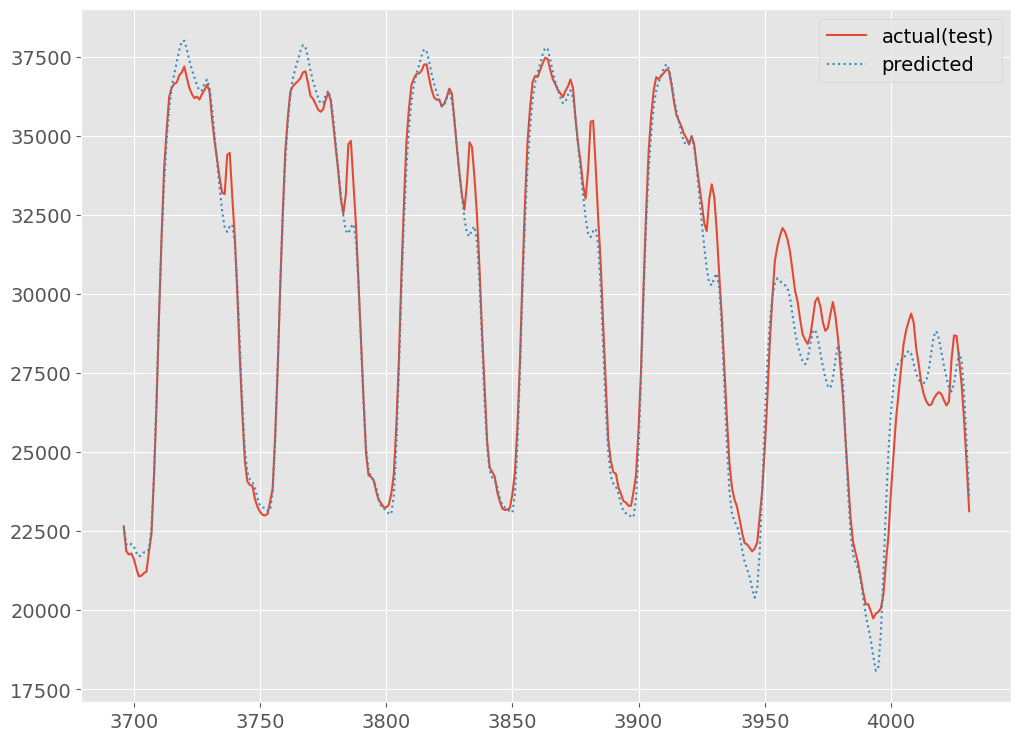

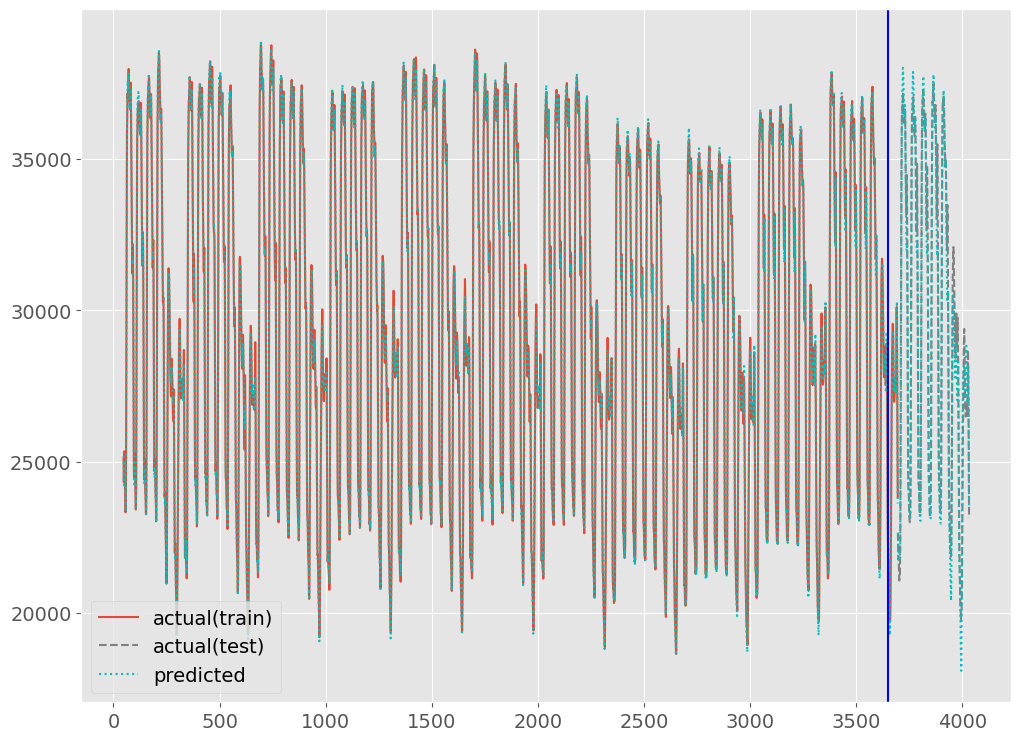

In [12]:
fig, ax = plt.subplots()

# 実測値
ax.plot(
    y_test.index, 
    y_test.values, 
    linestyle='-',
    label='actual(test)')

# 予測値
ax.plot(
    y_test.index, 
    test_pred, 
    linestyle=':',
    label="predicted") 

# 凡例表示
ax.legend()

plt.show()


# In[9]:


#
# グラフ（予測値と実測値）
#

fig, ax = plt.subplots()

# 実測値の描写
## 学習データ
ax.plot(
    y_train.index,
    y_train.values, 
    linestyle='-',
    label='actual(train)')

## テストデータ
ax.plot(
    y_test.index, 
    y_test.values,
    linestyle='--',
    label='actual(test)',
    color='gray')

# 予測値の描写
## 学習データ
ax.plot(
    y_train.index,
    train_pred, 
    linestyle=':',
    color='c')

## テストデータ
ax.plot(
    y_test.index,
    test_pred,
    linestyle=':',
    label="predicted",
    color='c') 

# 学習データとテスデータの間の縦線の描写
ax.axvline(
    len(y_train),
    color='blue')

# 凡例表示
ax.legend()

plt.show()
